In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

CSV_PATH = Path("speed_to_lead.csv")  

df = pd.read_csv(CSV_PATH, parse_dates=["created_at"])
df = df.dropna(subset=["response_minutes", "converted"]).copy()
df["response_minutes"] = df["response_minutes"].clip(1, 5*24*60)  # cap at 5 days
df["converted"] = df["converted"].astype(int)
df["deal_value"] = df["deal_value"].astype(float)

df.head()


,lead_id,created_at,owner,source,segment,response_minutes,converted,deal_value
0,L00001,2025-05-11 15:46:46,rep_04,Paid,Mid-Market,112,1,11951.51
1,L00002,2024-06-22 08:56:59,rep_12,Paid,SMB,40,0,0.00
2,L00003,2025-02-27 14:22:08,rep_01,Paid,SMB,14,1,20207.68
3,L00004,2024-03-13 18:36:21,rep_01,Paid,SMB,220,0,0.00
4,L00005,2025-03-11 22:21:58,rep_09,Paid,Mid-Market,4,1,6113.87


In [2]:
# Basic features
df["response_hours"] = (df["response_minutes"] / 60).clip(upper=120)
df["dow"] = df["created_at"].dt.dayofweek            # 0=Mon
df["hour"] = df["created_at"].dt.hour
df["in_biz_hours"] = ((df["hour"] >= 8) & (df["hour"] <= 18)).astype(int)
df["revenue_realized"] = np.where(df["converted"]==1, df["deal_value"], 0.0)

# Buckets for easy analysis
bins = [0,1,3,6,12,24,48,72,120]
labels = ["<=1h","1-3h","3-6h","6-12h","12-24h","24-48h","48-72h","72-120h"]
df["resp_bucket"] = pd.cut(df["response_hours"], bins=bins, labels=labels, include_lowest=True, right=True)


df.shape, df.dtypes


((1500, 14),
 lead_id                     object
 created_at          datetime64[ns]
 owner                       object
 source                      object
 segment                     object
 response_minutes             int64
 converted                    int64
 deal_value                 float64
 response_hours             float64
 dow                          int32
 hour                         int32
 in_biz_hours                 int64
 revenue_realized           float64
 resp_bucket               category
 dtype: object)

In [3]:
print("Rows:", len(df))
print("Overall conversion %:", round(100*df["converted"].mean(), 2))
print("Median response (min):", int(df["response_minutes"].median()))
print("Avg deal value (wins only):", round(df.loc[df["converted"]==1, "deal_value"].mean(), 2))

print("\nConversion by response bucket (%):")
conv_by_bucket = df.groupby("resp_bucket")["converted"].mean().mul(100).round(2)
print(conv_by_bucket)

print("\nConversion by source x segment (%):")
pivot = df.pivot_table(values="converted", index="source", columns="segment", aggfunc="mean").mul(100).round(2)
print(pivot)

print("\nOwner leaderboard (conv% and median response mins):")
owner = df.groupby("owner").agg(conv=("converted","mean"),
                                med_resp=("response_minutes","median")).sort_values("conv", ascending=False)
owner["conv"] = (owner["conv"]*100).round(2)
owner["med_resp"] = owner["med_resp"].round(0).astype(int)
print(owner.head(10))


Rows: 1500
Overall conversion %: 8.73
Median response (min): 167
Avg deal value (wins only): 9198.15

Conversion by response bucket (%):
resp_bucket
<=1h       16.48
1-3h       10.21
3-6h        4.86
6-12h       2.95
12-24h      2.38
24-48h      0.00
48-72h       NaN
72-120h      NaN
Name: converted, dtype: float64

Conversion by source x segment (%):
segment   Enterprise  Mid-Market    SMB
source                                 
Event          11.76       12.82   7.69
Organic         2.63        7.91  11.82
Paid            2.56        8.42   5.88
Referral        4.00       14.63  13.19

Owner leaderboard (conv% and median response mins):
         conv  med_resp
owner                  
rep_04  15.38       141
rep_09  12.37       224
rep_02  10.87       202
rep_07  10.58       140
rep_06   9.09       156
rep_14   8.65       140
rep_10   8.46       166
rep_05   8.16       174
rep_01   7.92       157
rep_11   7.89       145


/var/folders/h9/gzr74y057cg4kqqvn88zchwm0000gn/T/ipykernel_12099/1706756873.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  conv_by_bucket = df.groupby("resp_bucket")["converted"].mean().mul(100).round(2)


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss
import numpy as np
import pandas as pd

# Ensure this is after your Step 1–2 where df is prepared
work = df.copy()
work["log_resp_min"] = np.log1p(work["response_minutes"])

# One-hot with fixed reference set (drop_first to keep things lean)
X = pd.get_dummies(
    work[["log_resp_min", "in_biz_hours", "source", "segment", "dow"]],
    drop_first=True
)
y = work["converted"].values

# 👉 Lock the training columns (order + names)
train_cols = X.columns

clf = LogisticRegression(max_iter=200)
clf.fit(X, y)

probs = clf.predict_proba(X)[:, 1]
print("AUC:", round(roc_auc_score(y, probs), 3), "| LogLoss:", round(log_loss(y, probs), 3))

AUC: 0.721 | LogLoss: 0.274


In [5]:
def pdp_response_minutes(model, x_template: pd.DataFrame, minutes_grid=None):
    if minutes_grid is None:
        minutes_grid = np.arange(1, 5*24*60+1, 30)  # every 30 mins up to 5 days
    fixed = x_template.copy()
    out = []
    for rm in minutes_grid:
        tmp = fixed.copy()
        tmp["log_resp_min"] = np.log1p(rm)
        p = model.predict_proba(tmp)[:,1].mean()
        out.append({"response_minutes": rm, "pred_conv": p})
    return pd.DataFrame(out)

x_template = X.copy()  # use the observed mix for marginal averaging
pdp = pdp_response_minutes(clf, x_template)
pdp.head()


,response_minutes,pred_conv
0,1,0.354442
1,31,0.136424
2,61,0.104733
3,91,0.089037
4,121,0.079132


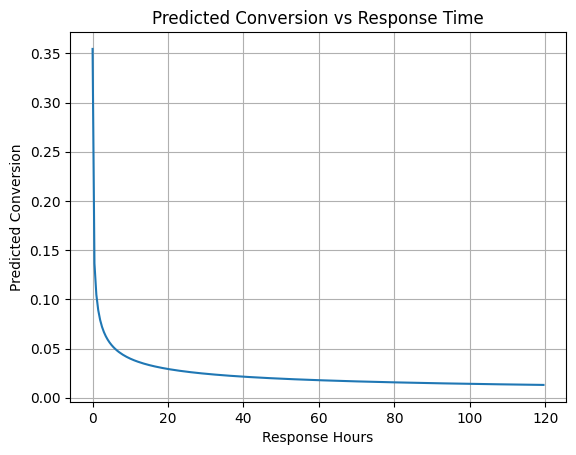

In [6]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(pdp["response_minutes"]/60.0, pdp["pred_conv"])
plt.xlabel("Response Hours")
plt.ylabel("Predicted Conversion")
plt.title("Predicted Conversion vs Response Time")
plt.grid(True)
plt.show()


In [9]:
def make_X_from(df_in: pd.DataFrame, use_cols) -> pd.DataFrame:
    tmp = df_in.copy()
    if "log_resp_min" not in tmp:
        tmp["log_resp_min"] = np.log1p(tmp["response_minutes"])
    X_tmp = pd.get_dummies(
        tmp[["log_resp_min", "in_biz_hours", "source", "segment", "dow"]],
        drop_first=True
    )
    # 👉 Force exact same columns as training (missing -> 0, extras dropped)
    X_tmp = X_tmp.reindex(columns=use_cols, fill_value=0)
    return X_tmp


In [10]:
def simulate_sla(model, df_original: pd.DataFrame, sla_hours: float, train_cols) -> dict:
    temp = df_original.copy()

    # Baseline predictions
    X_now = make_X_from(temp, train_cols)
    p_now = model.predict_proba(X_now)[:, 1]

    # SLA-capped predictions
    capped_minutes = np.minimum(temp["response_minutes"].values, sla_hours * 60.0)
    temp_sla = temp.copy()
    temp_sla["log_resp_min"] = np.log1p(capped_minutes)
    X_sla = make_X_from(temp_sla, train_cols)
    p_sla = model.predict_proba(X_sla)[:, 1]

    ev_now = float((p_now * temp["deal_value"].values).sum())
    ev_sla = float((p_sla * temp["deal_value"].values).sum())

    return {
        "sla_hours": sla_hours,
        "baseline_expected_wins": float(p_now.sum()),
        "sla_expected_wins": float(p_sla.sum()),
        "delta_wins": float(p_sla.sum() - p_now.sum()),
        "baseline_expected_revenue": ev_now,
        "sla_expected_revenue": ev_sla,
        "delta_revenue": float(ev_sla - ev_now),
    }

# Example:
res_3h = simulate_sla(clf, df, sla_hours=3.0, train_cols=train_cols)
res_3h


{'sla_hours': 3.0,
 'baseline_expected_wins': 130.94490407841045,
 'sla_expected_wins': 142.95348066758677,
 'delta_wins': 12.008576589176329,
 'baseline_expected_revenue': 159283.43090194452,
 'sla_expected_revenue': 163048.99146021894,
 'delta_revenue': 3765.5605582744174}

In [11]:
def simulate_segment_slas(model, df_original: pd.DataFrame, sla_map: dict, train_cols):
    rows = []
    for seg, h in sla_map.items():
        subset = df_original[df_original["segment"] == seg]
        if subset.empty:
            continue
        r = simulate_sla(model, subset, sla_hours=h, train_cols=train_cols)
        r["segment"] = seg
        rows.append(r)
    return pd.DataFrame(rows)

sla_targets = {"SMB": 2.0, "Mid-Market": 3.0, "Enterprise": 6.0}
seg_results = simulate_segment_slas(clf, df, sla_targets, train_cols)
seg_results[["segment", "sla_hours", "delta_wins", "delta_revenue"]].sort_values("delta_revenue", ascending=False)


,segment,sla_hours,delta_wins,delta_revenue
0,SMB,2.0,7.146796,3410.395637
1,Mid-Market,3.0,2.059419,385.032574
2,Enterprise,6.0,0.152012,0.000000
